In [1]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import random
from collections import Counter    # 计数类
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.utils.data as Data
import numpy as np
from torch import optim

# 数据集定义

## 原始数据集

### 语音数据集

In [2]:
soundmark = ['ei', 'bi:', 'si:', 'di:', 'i:',  
             'ef', 'dʒi:', 'eit∫', 'ai', 'dʒei', 
             'kei', 'el', 'em', 'en', 'əu', 
             'pi:', 'kju:', 'ɑ:', 'es', 'ti:', 
             'ju:', 'vi:', 'd∧blju:', 'eks', 'wai', 
             'zi:']

### 字母数据集

In [3]:
alphabet = ['a', 'b', 'c', 'd', 'e',
            'f', 'g', 'h', 'i', 'j',
            'k', 'l', 'm', 'n', 'o',
            'p', 'q', 'r', 's', 't',
            'u', 'v', 'w', 'x', 'y',
            'z']

## 序列数据集

In [4]:
t = 10000 # 序列总条数
seq_len = 6  # 序列长度
r = 0.9   # 扰动项
# 原始序列（语音序列），目标序列（字母序列）
src_tokens, tgt_tokens = [], [] 

In [5]:
for i in range(t):
    src, tgt = [], []
    for j in range(seq_len):
        ind = random.randint(0, 25)
        src.append(soundmark[ind])
        if random.random() < r:
            tgt.append(alphabet[ind])
        else:
            tgt.append(alphabet[random.randint(0, 25)])
    src_tokens.append(src)
    tgt_tokens.append(tgt)

### 语音序列数据集

In [6]:
src_tokens[0:5]

[['ɑ:', 'əu', 'kju:', 'bi:', 'di:', 'zi:'],
 ['dʒi:', 'si:', 'dʒi:', 'wai', 'eks', 'kju:'],
 ['eit∫', 'wai', 'ti:', 'dʒi:', 'ei', 'ei'],
 ['el', 'pi:', 'ef', 'kju:', 'ti:', 'si:'],
 ['es', 'zi:', 'bi:', 'en', 'ai', 'wai']]

### 字母序列数据集

In [7]:
tgt_tokens[0:5]

[['r', 'o', 'q', 'b', 'm', 'z'],
 ['g', 'c', 'g', 'y', 'x', 'q'],
 ['h', 'y', 't', 'g', 'a', 'n'],
 ['b', 'p', 'a', 'q', 't', 'c'],
 ['s', 'z', 'b', 'n', 'i', 'y']]

## 字典数据集

In [8]:
flatten = lambda li: [item for sublist in li for item in sublist]      # 展平二维数组

In [9]:
class Vocab:
    def __init__(self, tokens):
        self.tokens = tokens  # 传入的tokens是二维列表
        self.token2index = {'<bos>': 0, '<eos>': 1}  # 先存好特殊词元
        # 将token按词频逆序排序后生成token到index字典
        self.token2index.update({
            token: index + 2
            for index, (token, freq) in enumerate(
                sorted(Counter(flatten(self.tokens)).items(), key=lambda x: x[1], reverse=True))
        }) 
        # index到token字典
        self.index2token = {index: token for token, index in self.token2index.items()}
 
    def __getitem__(self, query):
        # 单一索引
        if isinstance(query, (str, int)):
            if isinstance(query, str):
                return self.token2index.get(query, 0)
            elif isinstance(query, (int)):
                return self.index2token.get(query, '<unk>')
        # 数组索引
        elif isinstance(query, (list, tuple)):
            return [self.__getitem__(item) for item in query]
 
    def __len__(self):
        return len(self.index2token)

### 语音字典数据集

In [10]:
# 实例化语音字典数据集
src_vocab = Vocab(src_tokens)
# 语音字典数据集大小
print("src_vocab_size: {}".format(len(src_vocab)))

src_vocab_size: 28


### 字母字典数据集

In [11]:
# 实例化字母字典数据集
tgt_vocab = Vocab(tgt_tokens)
# 字母字典数据集大小
print("tgt_vocab_size: {}".format(len(tgt_vocab)))

tgt_vocab_size: 28


## 序列张量数据集

In [12]:
# 语音序列结尾增加填充标识<pad>，并转换为语音序列张量数据集
encoder_input = torch.tensor([src_vocab[line + ['<pad>']] for line in src_tokens])

In [13]:
# 语音序列开头增加开始标识<bos>，并转换为语音序列张量数据集
decoder_input = torch.tensor([src_vocab[['<bos>'] + line] for line in src_tokens])

In [14]:
# 字母序列结尾增加结束标识<eos>，并转换为字母序列张量数据集
decoder_output = torch.tensor([tgt_vocab[line + ['<eos>']] for line in tgt_tokens])

## 训练集和测试集

In [15]:
# 训练集和测试集比例8比2
train_size = int(len(encoder_input) * 0.8)
test_size = len(encoder_input) - train_size
print(train_size, test_size)

8000 2000


In [16]:
BATCH_SIZE = 16

In [17]:
# 自定义数据集函数
class MyDataSet(Data.Dataset):
    def __init__(self, enc_input, dec_input, dec_output):
        super(MyDataSet, self).__init__()
        self.enc_input = enc_input
        self.dec_input = dec_input
        self.dec_output = dec_output

    def __len__(self):
        return self.enc_input.shape[0]

    def __getitem__(self, idx):
        return self.enc_input[idx], self.dec_input[idx], self.dec_output[idx]

In [18]:
train_dataset = MyDataSet(encoder_input[:train_size], decoder_input[:train_size], decoder_output[:train_size])
test_dataset = MyDataSet(encoder_input[-test_size:], decoder_input[-test_size:], decoder_output[-test_size:])

In [19]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=1)

# 模型定义

## mask没有意义(=0)的占位符

In [20]:
def get_attn_pad_mask(seq_q, seq_k):  
    # seq_q: [batch_size, len_q], seq_k: [batch_size, len_k]
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq: 比较两个tensor中，每一个对应位置上的元素是否相等。相等则对应位置置True，不等则对应位置置False
    # 判断值为0（没有意义的占位符）的位置, 用True标记。 
    # pad_attn_mask: [batch_size, len_k]
    pad_attn_mask = seq_k.data.eq(0)
    # pad_attn_mask: [batch_size, 1, len_k]
    pad_attn_mask = pad_attn_mask.unsqueeze(1)  
    # expand: 参数是扩展的目标，repeat: 参数是重复的次数
    # pad_attn_mask: [batch_size, len_q, len_k]
    pad_attn_mask = pad_attn_mask.expand(batch_size, len_q, len_k)
    return pad_attn_mask

## mask未来信息

In [21]:
def get_attn_subsequence_mask(seq):   
    # seq: [batch_size, seq_len]
    # attn_shape: [batch_size, seq_len, seq_len]
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    # 生成右上三角矩阵（不包括主对角线）：[batch_size, seq_len, seq_len]
    # 右上三角矩阵中元素为1，其余位置元素为0
    # subsequence_mask: [batch_size, seq_len, seq_len]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1)  
    # self.byte() is equivalent to self.to(torch.uint8)
    # subsequence_mask: [batch_size, seq_len, seq_len]
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()  
    return subsequence_mask 

## 正余弦位置编码

In [22]:
def get_sinusoid_positional_encoding(n_position, d_model):
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_idx) for hid_idx in range(d_model)]
    # sinusoid_positional_encoding: [n_position, d_model]
    sinusoid_positional_encoding = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_positional_encoding[:, 0::2] = np.sin(sinusoid_positional_encoding[:, 0::2]) # 偶数位用正弦函数
    sinusoid_positional_encoding[:, 1::2] = np.cos(sinusoid_positional_encoding[:, 1::2]) # 奇数位用余弦函数
    # sinusoid_positional_encoding: [n_position, d_model]
    return torch.FloatTensor(sinusoid_positional_encoding)

## 缩放点积注意力

In [23]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()
    def forward(self, Q, K, V, attn_mask):
        '''
        Q: [batch_size, n_heads, len_q, d_q]  # d_q = d_k
        K: [batch_size, n_heads, len_k, d_k]
        V: [batch_size, n_heads, len_v, d_v]  # len_v = len_k
        attn_mask: [batch_size, n_heads, len_q, len_k]
        '''
        d_k = K.size(-1)
        # scores: [batch_size, n_heads, len_q, len_k]
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) 
        # scores: [batch_size, n_heads, len_q, len_k]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is True.
        # attn: [batch_size, n_heads, len_q, len_k]
        attn = nn.Softmax(dim=-1)(scores)
        # context: [batch_size, n_heads, len_q, d_v]
        context = torch.matmul(attn, V) 
        # context: [batch_size, n_heads, len_q, d_v], attn: [batch_size, n_heads, len_q, len_k]
        return context, attn

## 多头注意力

In [24]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_k, d_v):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        # bias用于指定是否在线性变换后添加偏置项
        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False)
        self.fc = nn.Linear(n_heads * d_v, d_model, bias=False)
    def forward(self, input_Q, input_K, input_V, attn_mask):
        '''
        input_Q: [batch_size, len_q, d_model]
        input_K: [batch_size, len_k, d_model]
        input_V: [batch_size, len_v, d_model]  # len_v = len_k
        attn_mask: [batch_size, len_q, len_k]
        '''
        residual, batch_size = input_Q, input_Q.size(0)
        # Q: [batch_size, len_q, d_model]变为[batch_size, n_heads, len_q, d_k]
        Q = self.W_Q(input_Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2) 
        # K: [batch_size, len_k, d_model]变为[batch_size, n_heads, len_k, d_k]
        K = self.W_K(input_K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2) 
        # V: [batch_size, len_v, d_model]变为[batch_size, n_heads, len_v, d_v]
        V = self.W_V(input_V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1,2) 
        # expand: 参数是扩展的目标，repeat: 参数是重复的次数
        # attn_mask : [batch_size, len_q, len_k]变为[batch_size, n_heads, len_q, len_k]
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1) 
        # context: [batch_size, n_heads, len_q, d_v]
        # attn: [batch_size, n_heads, len_q, len_k]
        context, attn = ScaledDotProductAttention()(Q, K, V, attn_mask)
        # context: [batch_size, len_q, n_heads * d_v]
        context = context.transpose(1, 2).reshape(batch_size, -1, self.n_heads * self.d_v) 
        # output: [batch_size, len_q, d_model]
        output = self.fc(context) 
        # 对应元素相加，不改变size，output: [batch_size, len_q, d_model]
        output = output + residual
        # 层归一化，不改变size，output: [batch_size, len_q, d_model]
        output = nn.LayerNorm(self.d_model)(output)
        # output: [batch_size, len_q, d_model]，attn: [batch_size, n_heads, len_q, len_k]
        return output, attn

## 前馈网络

In [25]:
class FeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForwardNet, self).__init__()
        self.d_model = d_model
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(d_ff, d_model, bias=False)
        )
        
    def forward(self, input):    
        # input: [batch_size, seq_len, d_model]
        residual = input
        # output: [batch_size, seq_len, d_model]
        output = self.fc(input)
        # 残差 + LayerNorm
        # output: [batch_size, seq_len, d_model]
        output = nn.LayerNorm(self.d_model)(output + residual)   
        return output

## 编码器层

In [26]:
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, d_ff, d_k, d_v):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(n_heads, d_model, d_k, d_v)  # 多头注意力
        self.ffn = FeedForwardNet(d_model, d_ff)  # 前馈网络
    def forward(self, enc_input, enc_self_attn_mask):
        '''
        enc_input: [batch_size, src_len, d_model]
        enc_self_attn_mask: [batch_size, src_len, src_len]
        '''
        # enc_input to same Q, K, V
        # enc_output: [batch_size, src_len, d_model], attn: [batch_size, n_heads, src_len, src_len]
        enc_output, attn = self.enc_self_attn(enc_input, enc_input, enc_input, enc_self_attn_mask) 
        # enc_output: [batch_size, src_len, d_model]
        enc_output = self.ffn(enc_output) 
        # enc_output: [batch_size, src_len, d_model], attn: [batch_size, n_heads, src_len, src_len]
        return enc_output, attn

## 编码器模块

In [27]:
class Encoder(nn.Module):
    def __init__(self, n_layers, n_heads, src_vocab_size, d_model, d_ff, d_k, d_v):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_positional_encoding(src_vocab_size, d_model), freeze=True)
        self.layers = nn.ModuleList([EncoderLayer(n_heads, d_model, d_ff, d_k, d_v) for _ in range(n_layers)])
    def forward(self, enc_input):
        '''
        enc_input: [batch_size, src_len]
        '''
        # word_emb: [batch_size, src_len, d_model]
        word_emb = self.src_emb(enc_input) 
        # pos_emb: [batch_size, src_len, d_model]
        pos_emb = self.pos_emb(enc_input) 
        # enc_output: [batch_size, src_len, d_model]
        enc_output = word_emb + pos_emb
        # enc_self_attn_mask: [batch_size, src_len, src_len]
        enc_self_attn_mask = get_attn_pad_mask(enc_input, enc_input) 
        enc_output_list = []
        enc_self_attn_list = []
        for layer in self.layers:
            # enc_output: [batch_size, src_len, d_model], enc_self_attn: [batch_size, n_heads, src_len, src_len]
            enc_output, enc_self_attn = layer(enc_output, enc_self_attn_mask)
            enc_output_list.append(enc_output)
            enc_self_attn_list.append(enc_self_attn)
        # enc_output_list: [n_layers, batch_size, src_len, d_model]
        # enc_self_attn_list: [n_layers, batch_size, n_heads, src_len, src_len]
        return enc_output_list, enc_self_attn_list

## 解码器层

In [28]:
class DecoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, d_ff, d_k, d_v):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention(n_heads, d_model, d_k, d_v)
        self.dec_enc_attn = MultiHeadAttention(n_heads, d_model, d_k, d_v)
        self.ffn = FeedForwardNet(d_model, d_ff)
    def forward(self, dec_input, enc_output, dec_self_attn_mask, dec_enc_attn_mask):
        '''
        dec_input: [batch_size, tgt_len, d_model]
        enc_output: [batch_size, src_len, d_model]
        dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
        dec_enc_attn_mask: [batch_size, tgt_len, src_len]
        '''       
        # dec_output: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
        dec_output, dec_self_attn = self.dec_self_attn(dec_input, dec_input, dec_input, dec_self_attn_mask)
        # dec_output: [batch_size, tgt_len, d_model], dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
        dec_output, dec_enc_attn = self.dec_enc_attn(dec_output, enc_output, enc_output, dec_enc_attn_mask)
        # dec_output: [batch_size, tgt_len, d_model]
        dec_output = self.ffn(dec_output) 
        # dec_output: [batch_size, tgt_len, d_model]
        # dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
        # dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
        return dec_output, dec_self_attn, dec_enc_attn

## 解码器模块

In [29]:
class Decoder(nn.Module):
    def __init__(self, n_layers, n_heads, tgt_vocab_size, d_model, d_ff, d_k, d_v):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_positional_encoding(tgt_vocab_size, d_model), freeze=True)
        self.layers = nn.ModuleList([DecoderLayer(n_heads, d_model, d_ff, d_k, d_v) for _ in range(n_layers)])
    def forward(self, dec_input, enc_input, enc_output_list):
        '''
        dec_input: [batch_size, tgt_len]
        enc_input: [batch_size, src_len]
        enc_output: [batsh_size, src_len, d_model]
        '''
        # word_emb: [batch_size, tgt_len, d_model]
        word_emb = self.tgt_emb(dec_input) 
        # pos_emb: [batch_size, tgt_len, d_model]
        pos_emb = self.pos_emb(dec_input) 
        # dec_output: [batch_size, tgt_len, d_model]
        dec_output = word_emb + pos_emb
        # dec_self_attn_pad_mask: [batch_size, tgt_len, tgt_len]
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_input, dec_input) 
        # dec_self_attn_subsequent_mask: [batch_size, tgt_len, tgt_len]
        dec_self_attn_subsequent_mask = get_attn_subsequence_mask(dec_input) 
        # dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0) 
        # dec_enc_attn_mask: [batc_size, tgt_len, src_len]
        dec_enc_attn_mask = get_attn_pad_mask(dec_input, enc_input) 
        dec_self_attn_list, dec_enc_attn_list = [], []
        for i in range(len(self.layers)):
            layer = self.layers[i]
            enc_output = enc_output_list[i]
            # dec_output: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
            dec_output, dec_self_attn, dec_enc_attn = layer(dec_output, enc_output, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attn_list.append(dec_self_attn)
            dec_enc_attn_list.append(dec_enc_attn)
        # dec_output: [batch_size, tgt_len, d_model], dec_self_attn: [n_layers, batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn: [n_layers, batch_size, h_heads, tgt_len, src_len]
        return dec_output, dec_self_attn_list, dec_enc_attn_list

## Transformer类

In [30]:
class Transformer(nn.Module):
    def __init__(self, n_layers, n_heads, src_vocab_size, tgt_vocab_size, d_model, d_ff, d_k, d_v):
        super(Transformer, self).__init__()
        self.encoder = Encoder(n_layers, n_heads, src_vocab_size, d_model, d_ff, d_k, d_v)
        self.decoder = Decoder(n_layers, n_heads, tgt_vocab_size, d_model, d_ff, d_k, d_v)
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False)
    def forward(self, enc_input, dec_input):
        '''
        enc_input: [batch_size, src_len]
        dec_input: [batch_size, tgt_len]
        '''
        # enc_output_list: [n_layers, batch_size, src_len, d_model]
        # enc_self_attn_list: [n_layers, batch_size, n_heads, src_len, src_len]
        enc_output_list, enc_self_attn_list = self.encoder(enc_input)
        # dec_output: [batch_size, tgt_len, d_model], dec_self_attn_list: [n_layers, batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn_list: [n_layers, batch_size, h_heads, tgt_len, src_len]
        dec_output, dec_self_attn_list, dec_enc_attn_list = self.decoder(dec_input, enc_input, enc_output_list)
        # dec_logits: [batch_size, tgt_len, tgt_vocab_size]
        dec_logits = self.projection(dec_output) 
        # dec_logits: [batch_size * tgt_len, tgt_vocab_size]
        dec_logits = dec_logits.view(-1, dec_logits.size(-1))
        # dec_logits: [batch_size * tgt_len, tgt_vocab_size]
        # enc_self_attn_list: [n_layers, batch_size, n_heads, src_len, src_len]
        # dec_self_attn_list: [n_layers, batch_size, n_heads, tgt_len, tgt_len]
        # dec_enc_attn_list: [n_layers, batch_size, h_heads, tgt_len, src_len]
        return dec_logits, enc_self_attn_list, dec_self_attn_list, dec_enc_attn_list

In [31]:
# n_layers: 有多少个encoder和decoder
# n_heads: Multi-Head Self Attention设置为8
# d_model: Embedding的维度
# d_ff: 前馈网络隐藏层维度
# d_k: K(=Q)的维度 
# d_v: V的维度 
model = Transformer(n_layers=6, n_heads=8, d_model=512, d_ff=2048, d_k=64, d_v=64, src_vocab_size=len(src_vocab), tgt_vocab_size=len(tgt_vocab))

# 模型训练

In [32]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.99)
# num_epochs = 50 # 训练50轮
num_epochs = 2

In [33]:
# 记录损失变化
loss_history = []
model.train()
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    for enc_input, dec_input, dec_output in train_loader:
        '''
        enc_input: [batch_size, src_len]
        dec_input: [batch_size, tgt_len]
        dec_output: [batch_size, tgt_len]
        '''
        # enc_input, dec_input, dec_output = enc_input.to(device), dec_input.to(device), dec_output.to(device)
        # output: [batch_size * tgt_len, tgt_vocab_size]
        # enc_self_attn_list: [n_layers, batch_size, n_heads, src_len, src_len]
        # dec_self_attn_list: [n_layers, batch_size, n_heads, tgt_len, tgt_len]
        # dec_enc_attn_list: [n_layers, batch_size, h_heads, tgt_len, src_len]
        output, enc_self_attn_list, dec_self_attn_list, dec_enc_attn_list = model(enc_input, dec_input)
        loss = criterion(output, dec_output.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print('Epoch:', '%d' % (epoch + 1), 'loss =', '{:.6f}'.format(avg_loss))

 50%|█████████████████████████████████████████▌                                         | 1/2 [04:13<04:13, 253.72s/it]

Epoch: 1 loss = 2.103910


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [07:43<00:00, 231.82s/it]

Epoch: 2 loss = 1.488285


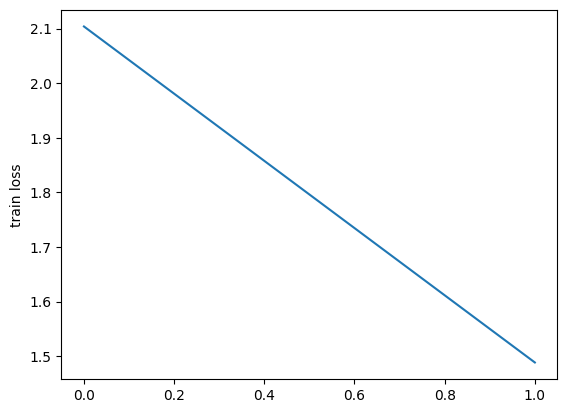

In [34]:
plt.plot(loss_history)
plt.ylabel('train loss')
plt.show()

# 模型测试

In [35]:
translation_results = []
correct = 0
error = 0
model.eval()
for enc_input, dec_input, dec_output in test_loader:
    '''
    enc_input: [batch_size=1, src_len]
    dec_input: [batch_size=1, tgt_len]
    dec_output: [batch_size=1, tgt_len]
    '''
    # enc_input, dec_input, dec_output = enc_input.to(device), dec_input.to(device), dec_output.to(device)
    # output: [batch_size * tgt_len, tgt_vocab_size]，即[tgt_len, tgt_vocab_size]
    output, enc_self_attn, dec_self_attn, dec_enc_attn = model(enc_input, dec_input)
    # squeeze(): 移除所有大小为1的维度
    # output: [tgt_len, tgt_vocab_size]
    output = output.squeeze()
    pred_seq = []
    for out in output:
        next_token_index = out.argmax().item()
        if next_token_index == tgt_vocab['<eos>']:
            break
        pred_seq.append(next_token_index)
    pred_seq = tgt_vocab[pred_seq]

    src_seq = enc_input.squeeze().tolist()  
    # 需要注意在<pad>之前截断
    if src_vocab['<pad>'] in src_seq:
        eos_idx = src_seq.index(src_vocab['<pad>'])
        src_seq = src_vocab[src_seq[:eos_idx]]
    else:
        src_seq = src_vocab[src_seq]
    
    tgt_seq = dec_output.squeeze().tolist()  
    # 需要注意在<eos>之前截断
    if tgt_vocab['<eos>'] in tgt_seq:
        eos_idx = tgt_seq.index(tgt_vocab['<eos>'])
        tgt_seq = tgt_vocab[tgt_seq[:eos_idx]]
    else:
        tgt_seq = tgt_vocab[tgt_seq]
        
    translation_results.append(('输入：' + ' '.join(src_seq), '输出：' + ' '.join(tgt_seq), '预测：' + ' '.join(pred_seq)))
    for i in range(len(tgt_seq)):
        if i >= len(pred_seq) or pred_seq[i] != tgt_seq[i]:
            error += 1
        else:
            correct += 1

In [36]:
print("correct: {}, error: {}, correct_ratio: {}".format(correct, error, correct / (correct + error)))
# correct: 5991, error: 6009, correct_ratio: 0.49925

correct: 5991, error: 6009, correct_ratio: 0.49925


In [37]:
translation_results[0:10]

[('输入：d∧blju: es di: ju: bi: es', '输出：w s d u y p', '预测：w b b b b'),
 ('输入：ti: si: d∧blju: d∧blju: zi: el', '输出：t c w w z l', '预测：t w w z l l'),
 ('输入：en vi: i: ai vi: vi:', '输出：n v e i v k', '预测：i v i v v'),
 ('输入：kju: əu en bi: em vi:', '输出：q w n b m v', '预测：q v b b m'),
 ('输入：vi: en kei kju: pi: ei', '输出：z n k q p a', '预测：v a a a a a'),
 ('输入：zi: ɑ: kei eks ai bi:', '输出：z r k x i g', '预测：z b b b b b'),
 ('输入：kei em wai vi: bi: zi:', '输出：k m y v b z', '预测：k z b b z z'),
 ('输入：en vi: ti: vi: kei bi:', '输出：n v t v k b', '预测：n v k k k b'),
 ('输入：bi: kei eks wai kju: es', '输出：b k x y q s', '预测：b q x q q'),
 ('输入：ti: zi: vi: el əu dʒi:', '输出：t z v l o g', '预测：t o o o g g')]